Soroush Famili, James Lu, Nithanth Ram

# Lab 9

This lab contains a number of different goals and ideas. The first part is low-level, and intended
to get you playing directly with pytorch. The middle part introduces you to the fascinating world of
Adversarial Attacks, but also gives practice with the important idea that you the power of torch (or
tensorflow) is that they allow you to compute derivatives of various kinds, and these can be used
for various interesting applications. Finally, the third part introduces you to powerful highlevel
tools built on top of pytorch. I hope that all of these ideas will be interesting, and also potentially
interesting and useful for your final projects.

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from sklearn.metrics import roc_auc_score
from scipy.signal import correlate

# Problem 1: Convolutions

#### 1. Compute the output of a 1D convolution layer if the input is a single-channel vector [1,-1,3,4,4] and the kernal is [1,1] for stride =1 and padding =0.


In [50]:
x1 = [1, -1, 3, 4, 4]
kernel1 = [1, 1]

output = correlate(x1, kernel1, mode="valid")

print(output)

[0 2 7 8]


### 2. Compute the output of a 1D convolution layer if the input is a single-channel vector [1,-1,3,4,4] and the kernal is [1,-1] for stride =1 and padding =1 (padding one means on both sides)


In [51]:
x2 = [0, 1, -1, 3, 4, 4, 0]
kernel2 = [1, -1]

output = correlate(x2, kernel2, mode="valid")

print(output)

[-1  2 -4 -1  0  4]


### 3.Write pytorch code that computes these outputs. Create the corresponding tensors and use torch.nn.Conv1d and ConvTranspose1d.

In [52]:
x_tensor = torch.tensor([[[1, -1, 3, 4, 4]]])
kernel1_tensor = torch.tensor([[[1, 1]]])
kernel2_tensor = torch.tensor([[[1, -1]]])

conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)
conv1.weight.data = kernel1_tensor
y1 = conv1(x_tensor)

conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=1, bias=False)
conv2.weight.data = kernel2_tensor
y2 = conv2(x_tensor)

print(f"Kernel={kernel1}, Padding=0, Convolution={y1}")
print(f"Kernel={kernel2}, Padding=1, Convolution={y2}")

Kernel=[1, 1], Padding=0, Convolution=tensor([[[0, 2, 7, 8]]], grad_fn=<SqueezeBackward1>)
Kernel=[1, -1], Padding=1, Convolution=tensor([[[-1,  2, -4, -1,  0,  4]]], grad_fn=<SqueezeBackward1>)


# Problem 2: Training a CIFAR-10 CNN classifier

In this problem we will follow a tutorial to build a Convolutional neural network that classifies
images from the CIFAR-10 dataset and then modify it.

## 1. Start by implementing and running this tutorial. https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/ Show the accuracy you get and also the confusion matrix you obtain for the 10 classes.

In [53]:
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

In [54]:
trainset = torchvision.datasets.CIFAR10(root='/home/CIFAR-10 Classifier Using CNN in PyTorch/data/',
                                       train=True,
                                       download=True,
                                       transform=transform)


Files already downloaded and verified


In [55]:
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=4,
                                         shuffle=True)

In [56]:
testset = torchvision.datasets.CIFAR10(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)

Files already downloaded and verified


In [57]:
testloader = torch.utils.data.DataLoader(testset,
                                        batch_size=4,
                                        shuffle=False)

In [58]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [59]:
def convert_to_imshow_format(image):
    image = image/2 + .5
    image = image.numpy()
    
    return image.transpose(1,2,0)

In [60]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

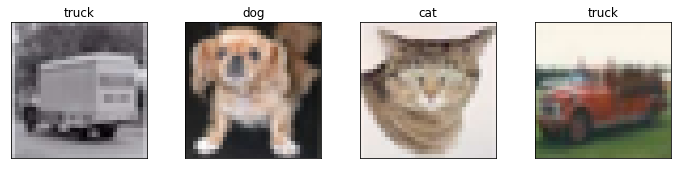

In [61]:
fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [62]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [63]:
net = Net()

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [65]:
model_directory_path = '/home/CIFAR-10 Classifier Using CNN in PyTorch/model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'
start_time = time.time()
if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):
        
        running_loss = 0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i%2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                
        print('Finished Training.')
        torch.save(net.state_dict(), model_path)
        print('Saved model parameters to disk.')
        print(f"{(time.time() - start_time)/60} minutes")

Loaded model parameters from disk.


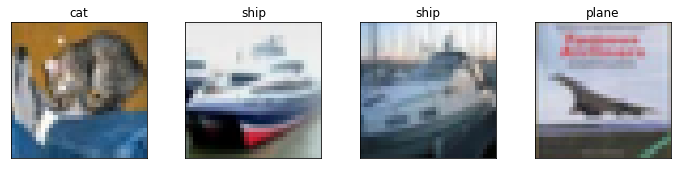

In [66]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [67]:
outputs = net(images)
outputs

tensor([[12.8378, 21.2135, -3.9512, -2.4074, -6.7323, -3.4238, -2.8449, -5.1073,
         -5.6707, -3.5788],
        [ 8.9530,  8.2867, -1.3748, -2.0256, -1.8785, -2.1281, -3.1845, -2.0973,
         -2.4251, -2.9838],
        [ 5.7865,  9.4060, -1.7701, -1.7893, -2.7732, -2.0195, -2.2053, -2.5030,
         -1.5214, -1.2776],
        [ 7.6079,  7.0279, -1.4036, -1.4569, -0.7085, -1.6605, -1.8269, -2.2497,
         -2.1339, -2.6285]], grad_fn=<AddmmBackward>)

In [68]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
sm_outputs

tensor([[2.3035e-04, 9.9977e-01, 1.1776e-11, 5.5140e-11, 7.2974e-13, 1.9955e-11,
         3.5600e-11, 3.7060e-12, 2.1098e-12, 1.7089e-11],
        [6.6063e-01, 3.3929e-01, 2.1608e-05, 1.1272e-05, 1.3058e-05, 1.0173e-05,
         3.5375e-06, 1.0492e-05, 7.5596e-06, 4.3236e-06],
        [2.6092e-02, 9.7381e-01, 1.3637e-05, 1.3378e-05, 5.0017e-06, 1.0628e-05,
         8.8251e-06, 6.5531e-06, 1.7489e-05, 2.2317e-05],
        [6.4075e-01, 3.5874e-01, 7.8168e-05, 7.4114e-05, 1.5664e-04, 6.0458e-05,
         5.1193e-05, 3.3540e-05, 3.7659e-05, 2.2966e-05]],
       grad_fn=<SoftmaxBackward>)

In [69]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

car - 0.9998
plane - 0.6606
car - 0.9738
plane - 0.6407


In [70]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 16.22%


In [71]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 63.5
car        - 98.7
bird       - 0.0
cat        - 0.0
deer       - 0.0
dog        - 0.0
frog       - 0.0
horse      - 0.0
ship       - 0.0
truck      - 0.0


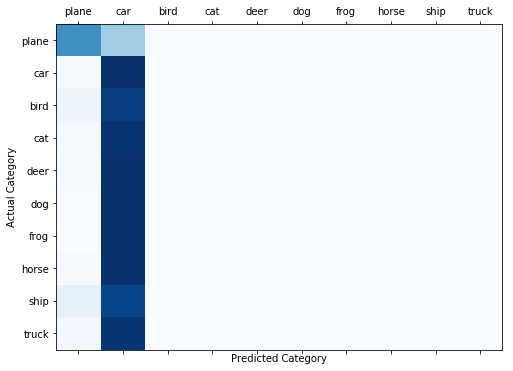

In [72]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [73]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           635       365       0         0         0         0         0         0         0         0         
                0.635     0.365     0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       
car             13        987       0         0         0         0         0         0         0         0         
                0.013     0.987     0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       
bird            56        944       0         0         0         0         0         0         0         0         
                0.056     0.944     0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       
cat             18        982       0         0         0         0         0         0         0         0         
                0.018     0.982     0.0       0.0       0.0     

## 2. Show the convolutional layer kernels you learned in the first convolutional layer.

In [74]:
def plot_kernels(tensor, num_cols=6):
    num_rows = 1
    fig = plt.figure(figsize=(num_cols, num_rows))
    i = 0
    for t in tensor:
        ax1 = fig.add_subplot(num_rows, num_cols, i+1)
        pilTrans = transforms.ToPILImage()
        pilImg = pilTrans(t)
        ax1.imshow(pilImg, interpolation='none')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        i += 1
    
    plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.show()

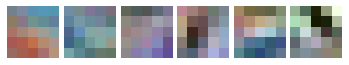

In [75]:
kernels = net.conv1.weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels/kernels.max()
plot_kernels(kernels)

## 3. Replace the architecture with AlexNet (https://github.com/icpm/pytorch-cifar10/blob/master/models/AlexNet.py) and report accuracy. Tune hyperparameters to get the best possible accuracy on a test set.

In [76]:
import torch.nn as nn

NUM_CLASSES = 10


class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [77]:
net = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [78]:
for epoch in range(2):

    running_loss = 0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')
    print(f"{(time.time() - start_time)/60} minutes")

KeyboardInterrupt: 

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [ ]:
ouputs = net(images)
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)

probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))
    
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

In [ ]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

## 4. Using the first CNN you trained, build another binary classifer that classifies images as ’Plane’ or ’Not Plane’. Compute the AUC of this binary classifier. Retrain this classifier to improve the AUC for this binary classification task. Report how you did that and what is the best AUC you were able to obtain.

In [ ]:
class BinaryNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(9, 26, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net = BinaryNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='/home/CIFAR-10 Classifier Using CNN in PyTorch/data/',
                                       train=True,
                                       download=True,
                                       transform=transform)

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)

In [ ]:
for target in range(len(trainset.targets)):
    if trainset.targets[target] != 0:
        trainset.targets[target] = 1

for target in range(len(testset.targets)):
    if testset.targets[target] != 0:
        testset.targets[target] = 1

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,
                                         shuffle=True)
testloader = torch.utils.data.DataLoader(testset,
                                        shuffle=False)

In [ ]:
for epoch in range(2):
        
    running_loss = 0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')
    print(f"{(time.time() - start_time)/60} minutes")

In [ ]:
ouputs = net(images)
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)

probs, index = torch.max(sm_outputs, dim=1)

total_correct = 0
total_images = 0

predictions = []
correct_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct_labels.extend(labels.numpy().tolist())
        predictions.extend(predicted.numpy().tolist())
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

print(f"AUC:{roc_auc_score(correct_labels, predictions)}")